# Prediction

## Data

In [1]:
import datetime
import time
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

##### Plotting

In [2]:
plt.figure(figsize = (6, 4))
sns.set_style("whitegrid", {'axes.linewidth': 1.5})
sns.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
# context = talk

#### Wunderground - weather data

In [3]:
start_date = datetime.datetime(2011,9,1)
end_date = datetime.datetime(2017,3,1)
places = ['NYC', 'LONDON', 'RJTD']
# RJTD = Tokyo, Japan

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

nm_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
leap_years = [2012, 2016]

In [4]:
for place in places:
    start_time = time.time()
    exec("pres_low_{} = pd.Series()".format(place))
    exec("pres_avg_{} = pd.Series()".format(place))
    exec("pres_high_{} = pd.Series()".format(place))
    
    for i in range(0, (diff_month(end_date, start_date)) + 1):
        year = (start_date + relativedelta(months = +i)).year
        month = (start_date + relativedelta(months = +i)).month

        page = open('weather/{}/wunderground_{}_{}_{}.txt'.format(place, place, year, month), 'r')
        soup = BeautifulSoup(page, 'html.parser')

        table = soup.find('table', attrs = {"class" : "responsive obs-table daily"})
        rows = table.findAll('tr')

        monthly_history =[]
        for tr in rows:
            cols = tr.findAll('td')
            text_data = []
            for td in cols:
                monthly_history.append(td.text.strip())

        if year in leap_years and month == 2:
            days = nm_days[month - 1] + 1
        else:
            days = nm_days[month - 1]

        df = pd.DataFrame()
        labels = monthly_history[0:21]

        for row in range(1, (days + 1)):
            for col in range(0, 21):
                df.loc[row, col] = monthly_history[21*row + col]

        df.columns = labels

        df['year'] = year
        df['month'] = month
        df['day'] = df.iloc[:,0]
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df.set_index('date')

        exec("pres_low_{} = pres_low_{}.append(pd.Series(df.iloc[:, 10]))".format(place, place))
        exec("pres_avg_{} = pres_avg_{}.append(pd.Series(df.iloc[:, 11]))".format(place, place))
        exec("pres_high_{} = pres_high_{}.append(pd.Series(df.iloc[:, 12]))".format(place, place))
        
    exec("print('{} is ready')".format(place))
    print("--- %s seconds ---" % (time.time() - start_time))

NYC is ready
--- 148.27323246002197 seconds ---
LONDON is ready
--- 146.0302231311798 seconds ---
RJTD is ready
--- 138.14222693443298 seconds ---


In [5]:
for place in places:
    exec("df_pres{} = pd.concat([pres_high_{}, pres_avg_{}, pres_low_{}], axis = 1)".format(place, place, place, place))
    exec("df_pres{}.columns = ['low_{}', 'avg_{}', 'high_{}']".format(place, place, place, place))
    exec("df_pres{} = df_pres{}.replace('-', np.nan)".format(place, place))

In [6]:
df_presNYC = df_presNYC.astype(float).interpolate(method = 'linear')
df_presRJTD = df_presRJTD.replace(np.nan, 0)

In [7]:
for place in places:    
    exec("df_pres{}['in_day_diff1_{}'] = df_pres{}.high_{}.astype(float) - df_pres{}.avg_{}.astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['in_day_diff2_{}'] = df_pres{}.low_{}.astype(float) - df_pres{}.avg_{}.astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['between_days_diff_{}'] = df_pres{}.low_{}.astype(float) - df_pres{}.high_{}.shift(1).astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['between_weeks_diff_{}'] = df_pres{}.low_{}.astype(float) - df_pres{}.high_{}.shift(7).astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{} = df_pres{}.bfill()".format(place, place))
    exec("df_pres{} = df_pres{}.drop(['low_{}', 'avg_{}', 'high_{}'], 1)".format(place, place, place, place, place))
    # exec("df_pres{} = df_pres{}.replace(np.nan, 0)".format(place, place))

#### Bitcoincharts

In [8]:
charts = ['bitbay', 'bitkonan', 'bitstamp', 'hitbtc', 'itbit', 'kraken', 'localbtc', 'rock']
data = {}
labels = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)', 'Weighted Price']

for index, chart in enumerate(charts): 
    exec("with open('data/{}.json') as fi: data[chart] = json.load(fi)".format(chart)) 
    exec("df{} = pd.DataFrame.from_records(data[chart], columns = labels)".format(index))
    exec("df{}['Date'] = pd.to_datetime(df{}['Timestamp'], unit = 's')".format(index, index))
    exec("df{}.set_index('Date', inplace = True)".format(index))
    exec("df{}.drop('Timestamp', 1, inplace = True)".format(index))
    exec("df{} = df{}.replace(1.7e+308, np.nan)".format(index, index))

***

## Model

In [9]:
from sklearn import metrics
from sklearn import linear_model, tree, neighbors

### Preprocessing

In [10]:
df = df2.copy()
df = df.loc[:, ('Close', 'Open')]
df = df.interpolate(method = 'linear')

df['dayofweek'] = df.index.map(lambda x: x.dayofweek)
df['doy'] = df.index.map(lambda x: x.dayofyear)
df['month'] = df.index.map(lambda x: x.month)
df['woy'] = df.index.map(lambda x: x.weekofyear)
df['qrt'] = df.index.map(lambda x: x.quarter)

df = pd.concat([df, df_presNYC, df_presLONDON, df_presRJTD], axis = 1)
df = df.ix['2013-01-01':]

df['weight'] = abs(df.Close.diff())

for s in [3, 7, 14]:
    df['weight{}'.format(s)] = df.weight.shift(s)
df = df.bfill()

In [11]:
df_class = df.copy()

df_class['target'] = df_class.Close.diff()

df_class.loc[df_class.target >= 0, 'target'] = 1
df_class.loc[df_class.target < 0, 'target'] = -1

df_class = df_class.replace(np.nan, 1)

***

In [12]:
start = '2016-01-01'
train = df_class[df_class.index < start]
val = df_class[start:]

y_train = train.target
y_val = val.target

del train['Close']
del val['Close']

del train['target']
del val['target']

del train['weight']
del val['weight']

In [13]:
models = [linear_model.LogisticRegression(penalty = 'l1')]
#tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)]
#neighbors.KNeighborsClassifier(n_neighbors = 10)

for model in models:
    model.fit(train, y_train)
    pred = model.predict(val)
    print('Model accuracy: %.3f, precision: %.3f, AUC: %.3f' %\
          (metrics.accuracy_score(y_val, pred), metrics.precision_score(y_val, pred), metrics.roc_auc_score(y_val, pred)))

Model accuracy: 0.434, precision: 0.586, AUC: 0.498


In [14]:
res = pd.DataFrame()
res['true'] = y_val
res['pred'] = pred

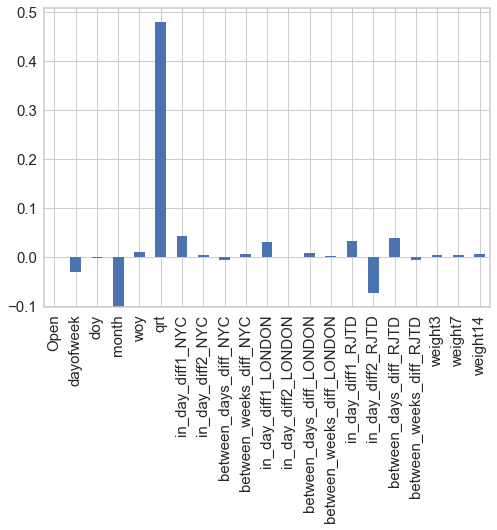

In [15]:
pd.Series(model.coef_[0], index = train.columns).plot(kind = 'bar')

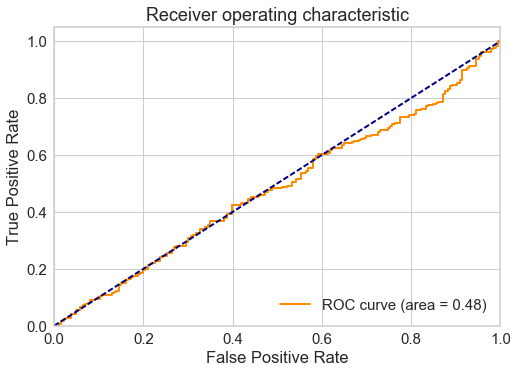

In [16]:
y_score = model.fit(train, y_train).decision_function(val)

fpr, tpr, _ = metrics.roc_curve(y_val, y_score) # false positive és true pozitív ráta számítása
roc_auc = metrics.auc(fpr, tpr) # görbe alatti terület számítása

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()